# This code is to summarize the statistical results related to phase precession of turning angle. Experimental data is based on Lomi et al, 2023. This code is written by Zilong Ji, 2024.

In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from numpy import deg2rad
from scipy.optimize import curve_fit
from scipy.stats import mannwhitneyu, wilcoxon
import sys
sys.path.append('/home/zilong/Desktop/HDPhasePrecession/CircularLinearReg')
from core import cl_corr
import HD_utils

%load_ext autoreload
%autoreload 2


In [70]:
def sinmodel(t, a, b, c, omega, t1, t2):
    return (a * (np.sin(2*np.pi*omega * t + np.pi/2) + 1) + b) * np.exp(-np.abs(t) / t1) + c * np.exp(-t**2 / t2**2) 

def calculate_intrinsic_frequency(autocorrelogram):

    # Fit the model to the autocorrelogram data
    initial_guess = [1, 1, 0.1, 9, 1.0, 0.01]  # Initial guesses for a, b, c, omega, t1, t2
    bounds = ([0, 0, 0, 6, 0, 0], [100, 100, 0.8, 12, 8, 0.05])  # Bounds for the parameters

    autocorr = autocorrelogram[0, :]
    #normalze autocorr to 0-1
    lags = autocorrelogram[1, :] / 1000.  # Convert lags to seconds

    params, _ = curve_fit(sinmodel, lags, autocorr, p0=initial_guess, bounds=bounds)
    # Extract the intrinsic frequency (omega)
    intrinsic_frequency = params[3]
    print(f"Intrinsic Theta Frequency: {intrinsic_frequency:.2f} Hz")
    
    return intrinsic_frequency, params

def skipmodel(t, a1, a2, b, c, omega, t1, t2):
    return (a1 * (np.cos(2*np.pi*omega * t) + 1) + a2 * (np.cos(np.pi*omega * t) + 1) + b) * np.exp(-np.abs(t) / t1) + c * np.exp(-t**2 / t2**2)

def calculate_skipping_index(autocorrelogram):
    # Fit the model to the autocorrelogram data
    initial_guess = [0.5, 0.5, 0.1, 0.1, 2 * 8, 0.01, 0.01]  # Initial guesses for a1, a2, b, c, omega, t1, t2
    bounds = ([0, 0, 0, -1, 10, 0, 0], [10, 10, 1, 1, 18, 5., 0.05])  # Bounds for the parameters

    autocorr = autocorrelogram[0, :]
    lags = autocorrelogram[1, :] / 1000  # Convert lags to seconds

    params, covariance = curve_fit(skipmodel, lags, autocorr, p0=initial_guess, bounds=bounds)
    omega = params[4] #freq

    # Calculate p1 and p2
    p1 = skipmodel(2 * np.pi / omega, *params)
    p2 = skipmodel(4 * np.pi / omega, *params)

    # Calculate the theta cycle skipping index
    TS = (p2 - p1) / max(p1, p2)
    
    print(f"Omega: {omega:.2f} Hz")
    print(f"Theta Cycle Skipping Index: {TS:.2f}")
    
    return omega, TS, params  # Return frequency in Hz and the TS index

def get_phaseprecession(ppoh, pot, pspt, psph, hd_mean, spike_phase, config):
    
    spike_phase = spike_phase + np.pi #[-pi, pi] -> [0, 2pi]
    
    speed_threshold = config['speed_threshold']
    duration_threshold = config['duration_threshold']
    speed_smooth_sigma = config['speed_smooth_sigma']
    
    #calculate angular speed
    angular_speed = HD_utils.calculate_angular_speed(ppoh, pot, sigma=speed_smooth_sigma)
    
    #convert psph to radian
    psph = deg2rad(psph)
    hd_mean = deg2rad(hd_mean)
    
    psph_centered = np.mod(psph - hd_mean + np.pi, 2 * np.pi)
    
    #CCW plot in ax1
    continuous_periods_CCW = HD_utils.find_continuous_periods(angular_speed, pot, speed_threshold=-speed_threshold, duration_threshold=duration_threshold)
    indx = []
    for i in range(len(continuous_periods_CCW)):
        indx.extend(np.where((pspt > continuous_periods_CCW[i][0]) & (pspt < continuous_periods_CCW[i][1]))[0])
        
    psph_CCW = psph_centered[indx]
    spike_phase_CCW = spike_phase[indx]
    
    
    #CW plot in ax2
    continuous_periods_CW = HD_utils.find_continuous_periods(angular_speed, pot, speed_threshold=speed_threshold, duration_threshold=duration_threshold)
    #keep the index when pspt is within continuous_periods
    indx = [] 
    for i in range(len(continuous_periods_CW)):
        indx.extend(np.where((pspt > continuous_periods_CW[i][0]) & (pspt < continuous_periods_CW[i][1]))[0])
    
    psph_CW = psph_centered[indx]
    spike_phase_CW = spike_phase[indx]
    
    
    #ax3 plot
    #flip   psph_CCW by 2pi - psph_CCW
    psph_CCW = 2 * np.pi - psph_CCW
    #combine CCW and CW togther and plot
    psph_combined = np.concatenate((psph_CCW, psph_CW))
    spike_phase_combined = np.concatenate((spike_phase_CCW, spike_phase_CW))
    
    circ_lin_corr, pval, slope, phi0, RR = cl_corr(psph_combined, spike_phase_combined, min_slope=-1/2/np.pi, max_slope=1/2/np.pi, bootstrap_iter=1000, return_pval=True)
    

    return pval, circ_lin_corr

def plot_autocorrelogram(ax, autocorrelogram):

    labelsize = 10
    ticksize = 8
    
    autocorr = autocorrelogram[0, :]

    ax.plot(autocorrelogram[1,:], autocorr, color='k', label='Autocorrelogram')

    intrinsic_frequency, params = calculate_intrinsic_frequency(autocorrelogram)

    #plot the fitted curve
    t = autocorrelogram[1,:]/1000
    #get the predicted y one by one
    y = []
    for i in range(len(t)):
        y.append(sinmodel(t[i], *params))
        
    ax.plot(t*1000, sinmodel(t, *params), color='red', label='Fitted curve', linewidth=1)
    
    ax.legend(frameon=False, loc='upper center', fontsize=8, ncol=1, bbox_to_anchor=(0.5, 1.3))
    
    ax.set_xticks([-500, 0, 500])   
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 
    
    ax.set_xlabel('Lag (ms)', fontsize=labelsize)
    ax.set_ylabel('Autocorrelation', fontsize=labelsize)
    
    #set x and y tick fontsize to 8
    ax.tick_params(axis='x', which='major', labelsize=ticksize)
    ax.tick_params(axis='y', which='major', labelsize=ticksize)
    
    
    return ax, intrinsic_frequency

def plot_thetaskipping(ax, autocorrelogram):
    
    labelsize = 10
    ticksize = 8
    
    autocorr = autocorrelogram[0, :]

    ax.plot(autocorrelogram[1,:], autocorr, color='k', label='Autocorrelogram')

    omega, TS, params = calculate_skipping_index(autocorrelogram)

    #plot the fitted curve
    t = autocorrelogram[1,:]/1000
        
    ax.plot(t*1000, skipmodel(t, *params), color='red', label='Fitted curve', linewidth=1)
    
    ax.legend(frameon=False, loc='upper center', fontsize=8, ncol=1, bbox_to_anchor=(0.5, 1.3))
    
    ax.set_xticks([-500, 0, 500])   
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 
    
    ax.set_xlabel('Lag (ms)', fontsize=labelsize)
    ax.set_ylabel('Autocorrelation', fontsize=labelsize)
    
    #set x and y tick fontsize to 8
    ax.tick_params(axis='x', which='major', labelsize=ticksize)
    ax.tick_params(axis='y', which='major', labelsize=ticksize)
    
    
    return ax, TS

## Section 1: extract information and perform circular-linear correlation analysis

In [4]:
base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'


# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'speed_threshold': 0.5,
    'duration_threshold': 0.5,
    'speed_smooth_sigma': 40,  #0.8,0.8,40 gives 43% pp cells
    'movingdirection_sigma': 5, #time bin size 20 ms, so 5 is 100 ms
    'interpolation_factor': 1, #1 is 0.02s, and 2 is 0.01s
    'IFR_window':0.2
}

total_hd_cells = 0

all_tw = []
nontheta_tw = []
theta_tw = []
theta_nonskip_tw = []
theta_skip_tw = []

all_intrinsic_freq = []
nontheta_intrinsic_freq = []
theta_intrinsic_freq = []
theta_nonskip_intrinsic_freq = []
theta_skip_intrinsic_freq = []

all_global_freq = []
nontheta_global_freq = []
theta_global_freq = []
theta_nonskip_global_freq = []
theta_skip_global_freq = []

all_ppp = []
nontheta_ppp = []
theta_ppp = []
theta_nonskip_ppp = []
theta_skip_ppp = []

all_clr = []
nontheta_clr = []
theta_clr = []
theta_nonskip_clr = []
theta_skip_clr = []

matnames = {}

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = HD_utils.load_data(ratname, file_path)
                
                if data_dict is not None:
                    ppoh = data_dict['poh']
                    pot = data_dict['pot'].flatten()
                    
                    ppox = data_dict['ppox'].flatten()
                    ppoy = data_dict['ppoy'].flatten()
                    global_freq = data_dict['global_freq'][0][0]
                    
                    #interpolte pot 
                    sampling_interval = np.diff(pot).mean()
                    new_interval = sampling_interval / config['interpolation_factor']
                    pot_interp = np.arange(0, pot[-1], new_interval)
                    
                    for cell_name, cell_data in data_dict['cells_data'].items():
                        psph = cell_data['psph'].flatten()
                        pspt = cell_data['pspt'].flatten()
                        spike_phase = cell_data['spike_phase'].flatten()
                        hd_pval = cell_data['pval'][0][0]
                        hd_mean = cell_data['hd_mean'][0][0]
                        hd_std = cell_data['hd_std'][0][0]
                        tune_width = cell_data['tune_width'][0][0]
                        autocorrelogram = cell_data['autocorrelogram']
                        intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                        hd_rayleigh = cell_data['hd_rayleigh'][0][0]
                        hd_rayleigh_shuffle_99 = cell_data['hd_rayleigh_shuffle_99'][0][0]
                        peak_fr = cell_data['peak_fr'][0][0]
                        intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                        cell_type = cell_data['cell_type']
                        
                        #store matname for each cell
                        matnames[cell_name] = [ratname, file_path]
                        
                        #if hd_pval < 0.05: #select only head direction tuned cells
                        if hd_rayleigh > hd_rayleigh_shuffle_99 and peak_fr > 1: #select only head direction tuned cells with rayleigh vector > 99% shuffle and the peak firing rate in the directional field is greater than 1 Hz
                            try:
                                #get results for phase precession against tuning angle
                                pval, clr = get_phaseprecession(ppoh, pot, pspt, psph, hd_mean, spike_phase, config)
                                
                                #save tuning width
                                all_tw.append(tune_width)
                                all_intrinsic_freq.append(intrinsic_freq)
                                all_global_freq.append(global_freq)
                                #save ppp 
                                all_ppp.append(pval)
                                #save circ-linear correlation
                                all_clr.append(clr)
                            
                                #save fig according to cell type in different folders
                                if 'Strong ThetaxHD' in cell_type: #This is a theta modulated HD cell
                                    
                                    #save tuning width
                                    theta_tw.append(tune_width)
                                    theta_intrinsic_freq.append(intrinsic_freq)
                                    theta_global_freq.append(global_freq)
                                    #save ppp
                                    theta_ppp.append(pval)
                                    #save circ-linear correlation
                                    theta_clr.append(clr)
 
                                    if 'skip'in cell_type: #this is a theta skipping cell
                                        #save tuning width
                                        theta_skip_tw.append(tune_width)
                                        theta_skip_intrinsic_freq.append(intrinsic_freq)
                                        theta_skip_global_freq.append(global_freq)
                                        #save ppp
                                        theta_skip_ppp.append(pval)
                                        #save circ-linear correlation
                                        theta_skip_clr.append(clr)
                                    elif 'Strong ThetaxHD' in cell_type: #this is a theta modulated non-skipping cell
                                        #save tuning width
                                        theta_nonskip_tw.append(tune_width)
                                        theta_nonskip_intrinsic_freq.append(intrinsic_freq)
                                        theta_nonskip_global_freq.append(global_freq)
                                        #save ppp
                                        theta_nonskip_ppp.append(pval)
                                        #save circ-linear correlation
                                        theta_nonskip_clr.append(clr)
                                elif 'HDC' in cell_type:
                                    nontheta_tw.append(tune_width)
                                    nontheta_intrinsic_freq.append(intrinsic_freq)
                                    nontheta_global_freq.append(global_freq)
                                    nontheta_ppp.append(pval)
                                    
                                    nontheta_clr.append(clr)
                                
                                total_hd_cells += 1
                            except Exception as e:
                                print(f"Error processing {cell_name}: {e}")
                        
print(f"Total number of HD cells processed: {total_hd_cells}")


Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170719_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_100919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_250719_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_090819_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_230819_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_200819_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhas

## Section 2: get the percentage of HD cells with significant phase precession of turning angle

ratio of pp in theta skipping cells: 0.2289156626506024
ratio of pp in theta non-skipping cells 0.13291139240506328
ratio of pp in classic HD cells 0.08823529411764706
theta skip cells: 19 83
theta nonskip cells: 21 158
nontheta HD cells: 12 136


/tmp/ipykernel_3435100/2179884856.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(categories, rotation=0, ha='center', fontsize=labelsize, va='center')


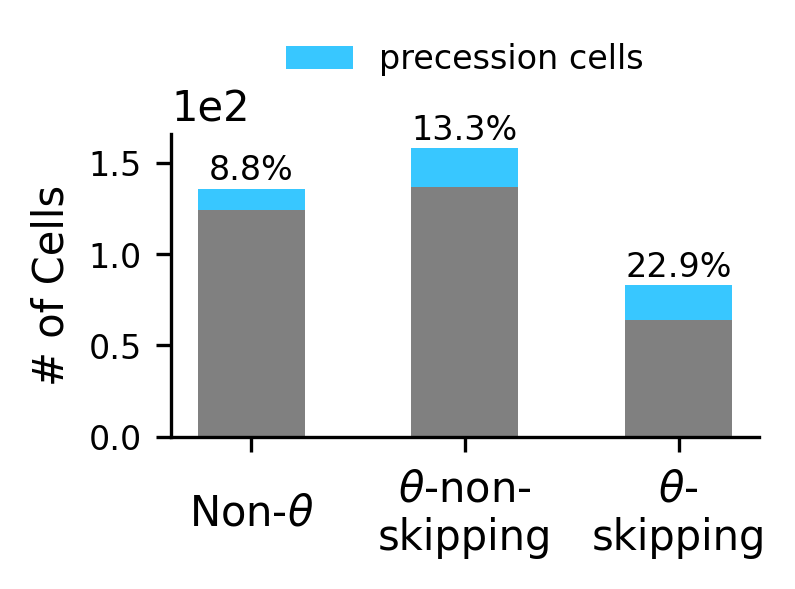

In [46]:
# ratio of pval_skip<0.05
# Create arrays for p-values
pval_skip = np.array(theta_skip_ppp)
pval_nonskip = np.array(theta_nonskip_ppp)
pval_nontheta = np.array(nontheta_ppp)

clr_skip = np.array(theta_skip_clr)
clr_nonskip = np.array(theta_nonskip_clr)
clr_nontheta = np.array(nontheta_clr)

# Calculate counts for p-values less than and greater than 0.05
skip_p_less = len(pval_skip[(pval_skip < 0.05) & (clr_skip <0)])
skip_p_more = len(pval_skip) - skip_p_less

nonskip_p_less = len(pval_nonskip[(pval_nonskip < 0.05) & (clr_nonskip <0)])
nonskip_p_more = len(pval_nonskip) - nonskip_p_less

nontheta_p_less = len(pval_nontheta[(pval_nontheta < 0.05) & (clr_nontheta <0)])
nontheta_p_more = len(pval_nontheta) - nontheta_p_less

# Print ratios
print('ratio of pp in theta skipping cells:', skip_p_less / len(pval_skip))
print('ratio of pp in theta non-skipping cells', nonskip_p_less / len(pval_nonskip))
print('ratio of pp in classic HD cells', nontheta_p_less / len(pval_nontheta))

#print the number of cells
print('theta skip cells:', skip_p_less, len(theta_skip_ppp))
print('theta nonskip cells:', nonskip_p_less, len(theta_nonskip_ppp))
print('nontheta HD cells:', nontheta_p_less, len(nontheta_ppp))



# Data for bar plot
categories = ['Non-'+r'$\theta$', r'$\theta$'+'-non-'+'\nskipping', r'$\theta$'+'-'+'\nskipping']
less_than_005 = [nontheta_p_less, nonskip_p_less, skip_p_less]
more_than_005 = [nontheta_p_more, nonskip_p_more, skip_p_more]

# Calculate percentages
total_cells = [nontheta_p_less + nontheta_p_more, nonskip_p_less + nonskip_p_more, skip_p_less + skip_p_more]
percent_less_than_005 = [100 * less / total for less, total in zip(less_than_005, total_cells)]
percent_more_than_005 = [100 * more / total for more, total in zip(more_than_005, total_cells)]

# Create stacked bar plot
fig, ax = plt.subplots(figsize=(2.8, 2.4), dpi=300)

labelsize = 10
ticksize = 8

bar_width = 0.5
bar1 = ax.bar(categories, more_than_005, bar_width, color='grey')
#label ha center, va center
bar2 = ax.bar(categories, less_than_005, bar_width, bottom=more_than_005, label='precession cells', color='#38c7ff')


ax.legend(frameon=False, loc='upper center', fontsize=8, bbox_to_anchor=(0.5, 1.4))

# Add labels and title
ax.set_ylabel('# of Cells', fontsize=labelsize)
#roatte xlabel 45 degree
ax.set_xticklabels(categories, rotation=0, ha='center', fontsize=labelsize, va='center')
#move xlabel closer to the plot
ax.tick_params(axis='x', pad=15)

# Add percentages on top of the higher bars
for i, (less, more, total) in enumerate(zip(less_than_005, more_than_005, total_cells)):
    ax.text(i, more + less + 10, f'{percent_less_than_005[i]:.1f}%', ha='center', va='center', color='black', fontsize=ticksize)

#tickfontsize
ax.tick_params(axis='y', which='major', labelsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()


plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/phaseprecession_percentage.pdf')

## Section 3: get the circular-linear correlation coefficient for three types of HD cells

pval between nontheta and theta nonskip: 0.01119856211669787
pval between nontheta and theta skip: 0.03974079379512625
pval between theta nonskip and theta skip: 0.9713031996077292


/tmp/ipykernel_3435100/2077516719.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Non-'+r'$\theta$', r'$\theta$'+'-non-'+'\nskipping', r'$\theta$'+'-'+'\nskipping'], rotation=0, ha='center', fontsize=labelsize-0.5, va='center')


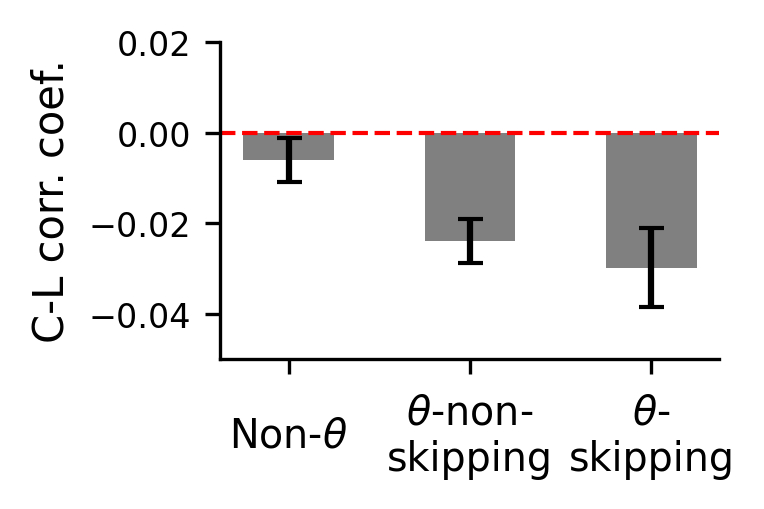

In [52]:
#plot clr for nontheta, theta nonskip, theta skip with mean and sem

# Create arrays for circ-linear correlation
clr_nontheta = np.array(nontheta_clr)
clr_theta_nonskip = np.array(theta_nonskip_clr)
clr_theta_skip = np.array(theta_skip_clr)

fig, ax = plt.subplots(figsize=(2.6, 1.8), dpi=300)

# Plot the mean and standard error of the circ-linear correlation
mean_clr_nontheta = np.mean(clr_nontheta)
sem_clr_nontheta = np.std(clr_nontheta) / np.sqrt(len(clr_nontheta))
mean_clr_theta_nonskip = np.mean(clr_theta_nonskip)
sem_clr_theta_nonskip = np.std(clr_theta_nonskip) / np.sqrt(len(clr_theta_nonskip))
mean_clr_theta_skip = np.mean(clr_theta_skip)
sem_clr_theta_skip = np.std(clr_theta_skip) / np.sqrt(len(clr_theta_skip))

# Plot the bars
bar_width = 0.5
bar1 = ax.bar(['Non-theta', 'Theta-non-'+'\nskipping', 'Theta-\nskipping'], [mean_clr_nontheta, mean_clr_theta_nonskip, mean_clr_theta_skip], bar_width, yerr=[sem_clr_nontheta, sem_clr_theta_nonskip, sem_clr_theta_skip], capsize=3, color='grey')

#add y=0
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.0)

#ylim
ax.set_ylim(-0.05, 0.02)
ax.set_yticks([-0.04, -0.02, 0, 0.02])

# Add labels and title
ax.set_ylabel('C-L corr. coef.', fontsize=labelsize)
#roatte xlabel 45 degree
ax.set_xticklabels(['Non-'+r'$\theta$', r'$\theta$'+'-non-'+'\nskipping', r'$\theta$'+'-'+'\nskipping'], rotation=0, ha='center', fontsize=labelsize-0.5, va='center')
#move xlabel closer to the plot
ax.tick_params(axis='x', pad=15)

# #y ticks in scientific notation
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

#tickfontsize
ax.tick_params(axis='y', which='major', labelsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#mannwhitneyu test between nontheta and theta nonskip
_, pval = mannwhitneyu(clr_nontheta, clr_theta_nonskip)
print('pval between nontheta and theta nonskip:', pval)

#mannwhitneyu test between nontheta and theta skip
_, pval = mannwhitneyu(clr_nontheta, clr_theta_skip)
print('pval between nontheta and theta skip:', pval)

#mannwhitneyu test between theta nonskip and theta skip
_, pval = mannwhitneyu(clr_theta_nonskip, clr_theta_skip)
print('pval between theta nonskip and theta skip:', pval)

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/clr_coefficient_in_three_celltypes.pdf')


## Section 4: plot the intrinsic frequency against global frequency for three types of HD cells. Note that I delete cells with global freqeuncy hit the 7 HZ or 12 Hz boundary (I guess fitting failed in this case).

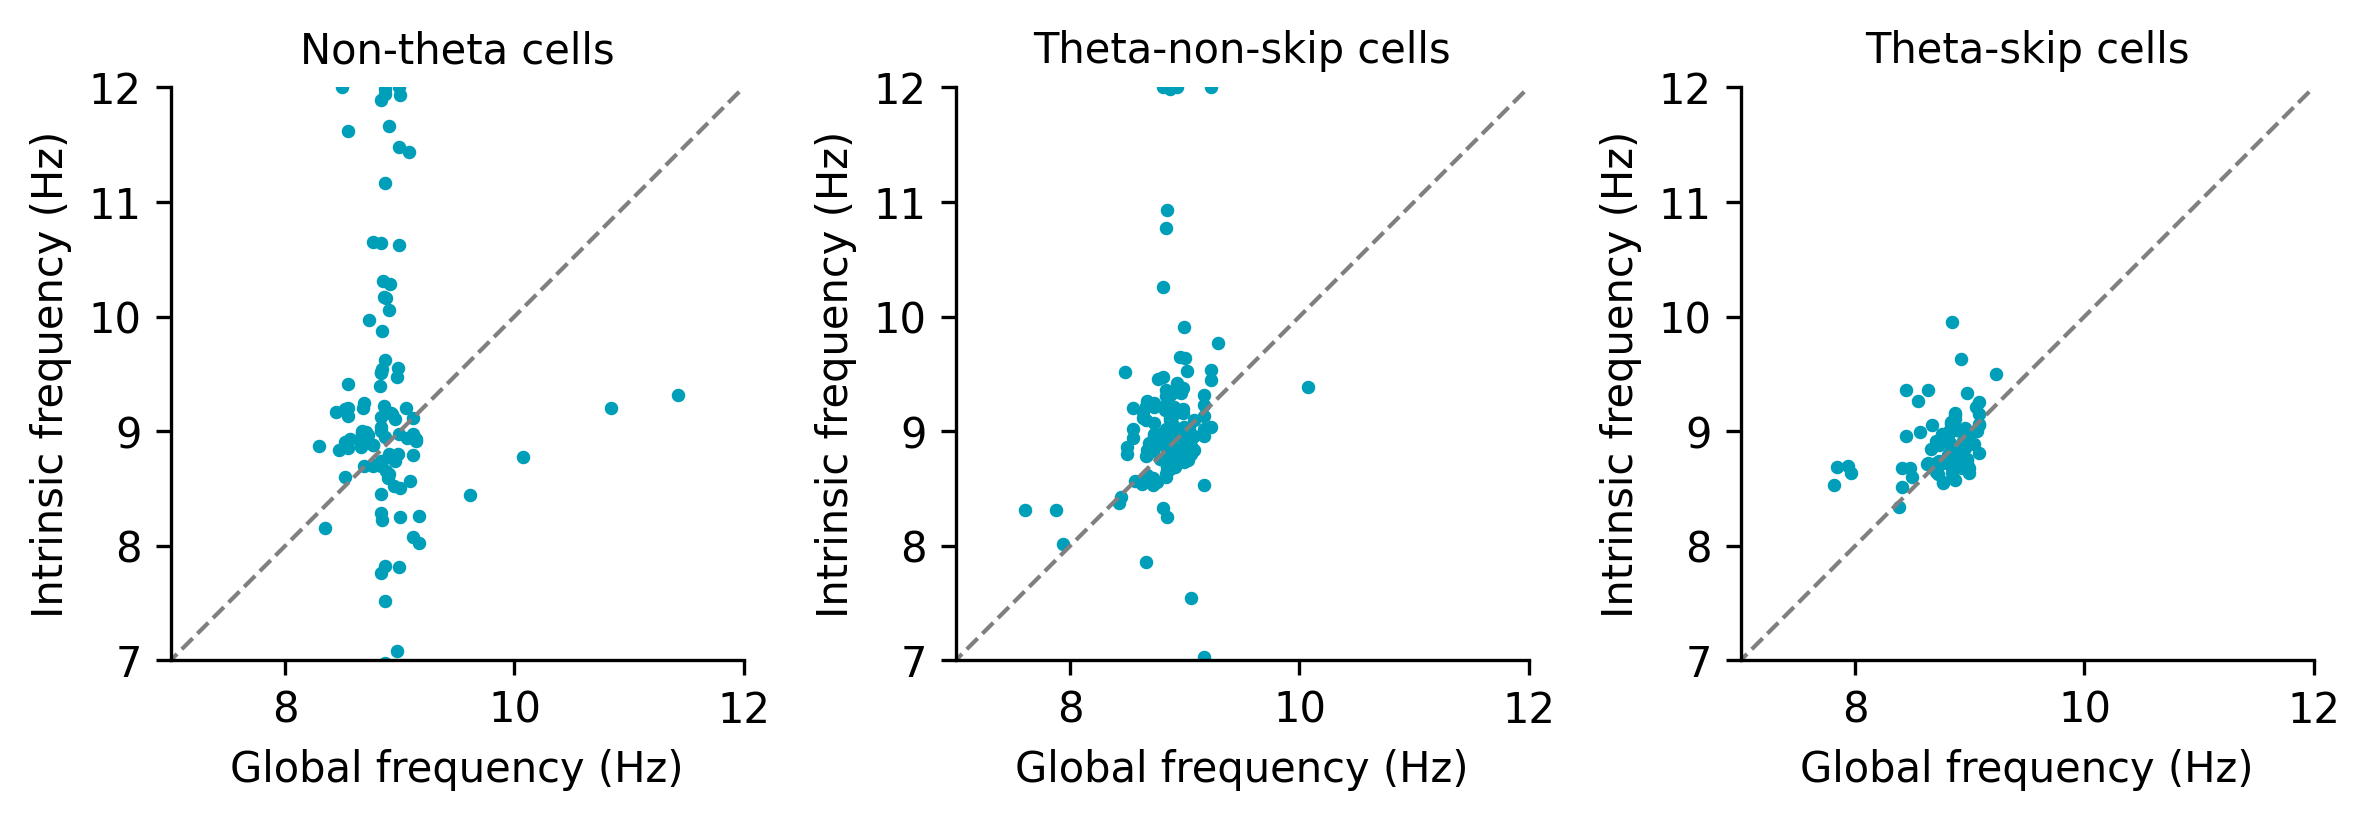

In [7]:


fig, axs = plt.subplots(1,3, figsize=(8, 3), dpi=300)

ax = axs[0]
#plot intrinsic freq against global freq for nontheta cells
#remove nontheta_global_freq when it is < 7.2
nontheta_global_freq = np.array(nontheta_global_freq)
nontheta_intrinsic_freq = np.array(nontheta_intrinsic_freq)
indx = np.where((nontheta_global_freq >= 7.2) & (nontheta_global_freq <=11.8))
ax.scatter(nontheta_global_freq[indx], 
           nontheta_intrinsic_freq[indx], 
           color='#009FB9', label='Non-theta', s=5)
ax.set_title('Non-theta cells', fontsize=labelsize)

ax = axs[1]
#plot intrinsic freq against global freq for theta nonskip cells
theta_nonskip_global_freq = np.array(theta_nonskip_global_freq)
theta_nonskip_intrinsic_freq = np.array(theta_nonskip_intrinsic_freq)
indx = np.where((theta_nonskip_global_freq >= 7.2) & (theta_nonskip_global_freq <=11.8))
ax.scatter(theta_nonskip_global_freq[indx], 
           theta_nonskip_intrinsic_freq[indx], 
           color='#009FB9', label='Theta-non-skip', s=5)
ax.set_title('Theta-non-skip cells', fontsize=labelsize)

ax = axs[2]
#plot intrinsic freq against global freq for theta skip cells
theta_skip_global_freq = np.array(theta_skip_global_freq)
theta_skip_intrinsic_freq = np.array(theta_skip_intrinsic_freq)
indx = np.where((theta_skip_global_freq >= 7.2) & (theta_skip_global_freq <=11.8))
ax.scatter(theta_skip_global_freq[indx], theta_skip_intrinsic_freq[indx], color='#009FB9', label='Theta-skip', s=5)
ax.set_title('Theta-skip cells', fontsize=labelsize)

for ax in axs:
    ax.set_xlim(7, 12)
    ax.set_ylim(7, 12)
    #equal aspect ratio
    ax.set_aspect('equal', 'box')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #add y=x line
    ax.plot([2, 13], [2, 13], color='grey', linestyle='--', linewidth=1.0)
    #x label
    ax.set_xlabel('Global frequency (Hz)', fontsize=labelsize)
    #y label
    ax.set_ylabel('Intrinsic frequency (Hz)', fontsize=labelsize)

plt.tight_layout()


## Section 4.2: plot intrinsic freq vs global freq specifically for significant phase precession cells

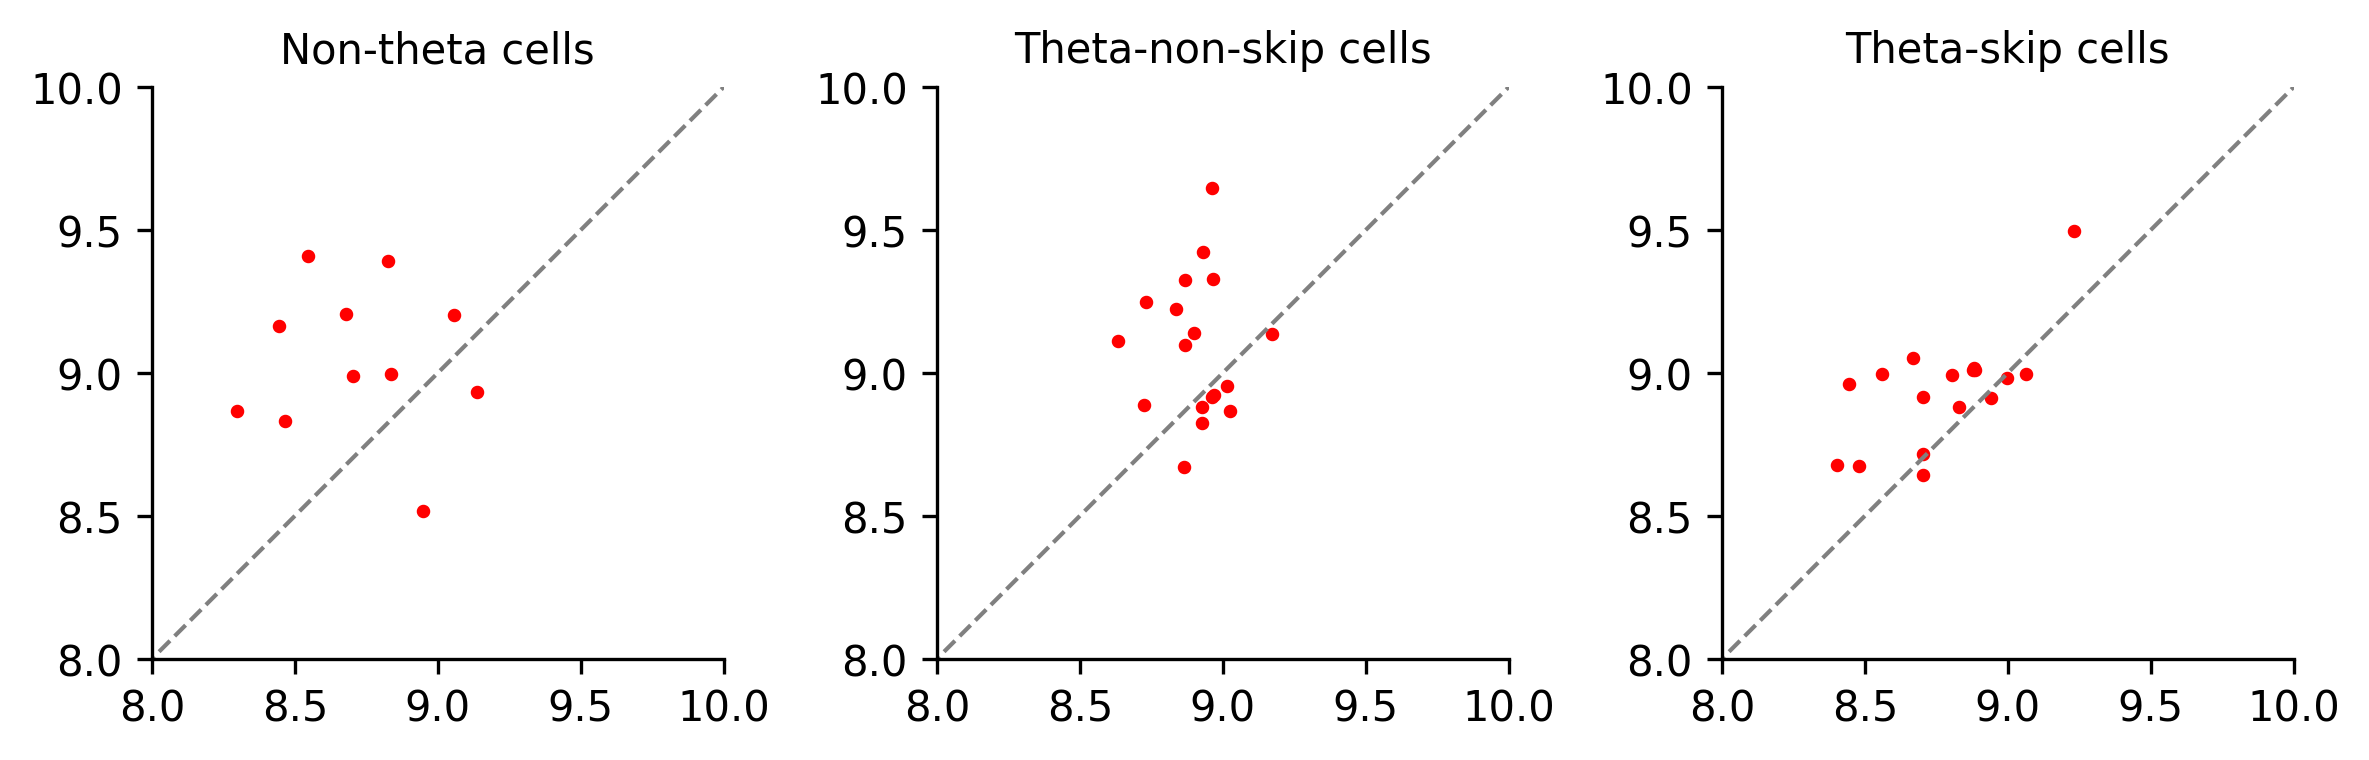

In [8]:
fig, axs = plt.subplots(1,3, figsize=(8, 3), dpi=300)

ax = axs[0]
#plot intrinsic freq against global freq for nontheta cells
#filter p < 0.05 and clr < 0 for nontheta_global_freq and nontheta_intrinsic_freq
indx = np.where((np.array(nontheta_ppp) < 0.05) 
                & (np.array(nontheta_clr) < 0)
                & (np.array(nontheta_global_freq) >= 7.2)
                & (np.array(nontheta_global_freq) <= 11.8))[0]
ax.scatter(np.array(nontheta_global_freq)[indx], 
           np.array(nontheta_intrinsic_freq)[indx], 
           color='red', label='Non-theta', s=5)
ax.set_title('Non-theta cells', fontsize=labelsize)

ax = axs[1]
#plot intrinsic freq against global freq for theta nonskip cells
#filter p < 0.05 for theta_nonskip_global_freq and theta_nonskip_intrinsic_freq
indx = np.where((np.array(theta_nonskip_ppp) < 0.05) 
                & (np.array(theta_nonskip_clr) < 0)
                & (np.array(theta_nonskip_global_freq) >= 7.2)
                & (np.array(theta_nonskip_global_freq) <= 11.8))[0]
ax.scatter(np.array(theta_nonskip_global_freq)[indx], 
           np.array(theta_nonskip_intrinsic_freq)[indx], 
           color='red', label='Theta-non-skip', s=5)
ax.set_title('Theta-non-skip cells', fontsize=labelsize)

ax = axs[2]
#plot intrinsic freq against global freq for theta skip cells
#filter p < 0.05 for theta_skip_global_freq and theta_skip_intrinsic_freq
indx = np.where((np.array(theta_skip_ppp) < 0.05) 
                & (np.array(theta_skip_clr) < 0)
                & (np.array(theta_skip_global_freq) >= 7.2)
                & (np.array(theta_skip_global_freq) <= 11.8))[0]
ax.scatter(np.array(theta_skip_global_freq)[indx], 
           np.array(theta_skip_intrinsic_freq)[indx], 
           color='red', label='Theta-skip', s=5)
ax.set_title('Theta-skip cells', fontsize=labelsize)

for ax in axs:
    ax.set_xlim(8, 10)
    ax.set_ylim(8, 10)
    #equal aspect ratio
    ax.set_aspect('equal', 'box')
    #add y=x line
    ax.plot([6, 12], [6, 12], color='grey', linestyle='--', linewidth=1.0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()

### merge all pp cells together

pval between nonpp and pp: 0.04908179322587179
pval between nonpp and 0: 0.0012081333337315163
pval between pp and 0: 8.272974810097367e-05


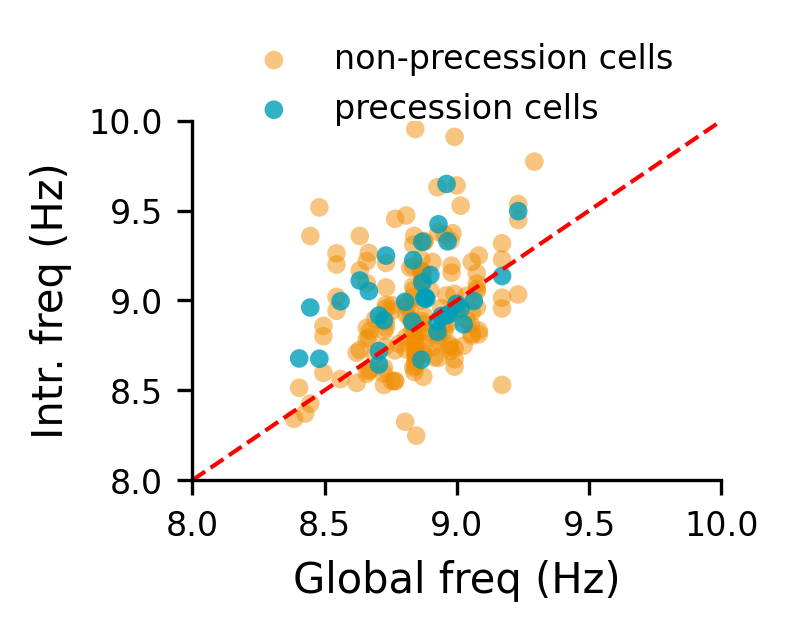

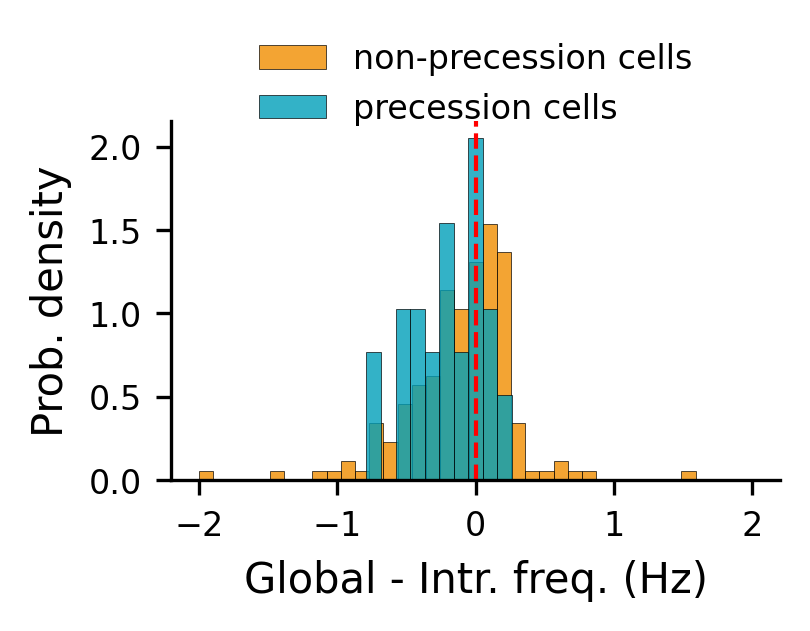

In [20]:
fig, ax = plt.subplots(figsize=(2.8, 2.4), dpi=300)

#filter theta_intrinsic_freq and theta_global_freq by their p < 0.05 and clr < 0

indx_pp = np.where((np.array(theta_ppp) < 0.05) 
                    & (np.array(theta_clr) < 0)
                    & (np.array(theta_global_freq) >= 7.2)
                    & (np.array(theta_global_freq) <= 11.8))[0]

#for cells with theta_ppp > 0.05, global freq > 7.2 and global freq < 11.8
indx_nonpp1 = np.where((np.array(theta_ppp) > 0.05)
                    & (np.array(theta_global_freq) >= 7.2)
                    & (np.array(theta_global_freq) <= 11.8))[0]
#or cells with theta_ppp < 0.05 & theta_clr >=0 and global freq > 7.2 and global freq < 11.8
indx_nonpp2 = np.where((np.array(theta_ppp) < 0.05)
                    & (np.array(theta_clr) >= 0)
                    & (np.array(theta_global_freq) >= 7.2)
                    & (np.array(theta_global_freq) <= 11.8))[0]
#combine them
indx_nonpp = np.concatenate((indx_nonpp1, indx_nonpp2)) 


ax.scatter(np.array(theta_global_freq)[indx_nonpp],
           np.array(theta_intrinsic_freq)[indx_nonpp],
           color='#F18D00', label='non-precession cells', s=20, alpha=0.5, edgecolors='none')

ax.scatter(np.array(theta_global_freq)[indx_pp],
           np.array(theta_intrinsic_freq)[indx_pp],
           color='#009FB9', label='precession cells', s=20, alpha=0.8, edgecolors='none')

ax.legend(frameon=False, loc='upper center', fontsize=8, ncol=1, bbox_to_anchor=(0.5, 1.3))

#add y=x
ax.plot([8, 10], [8, 10], color='red', linestyle='--', linewidth=1.0)

ax.set_xlim(8, 10)
ax.set_ylim(8, 10)
ax.set_xlabel('Global freq (Hz)', fontsize=labelsize)
ax.set_ylabel('Intr. freq (Hz)', fontsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='x', which='major', labelsize=ticksize)
ax.tick_params(axis='y', which='major', labelsize=ticksize)

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/intrinsic_vs_global_freq.pdf')


fig, ax = plt.subplots(1, 1, figsize=(2.8, 2.4), dpi=300)
#do a histogram plot of the difference between global freq - intrinsic freq
diff = np.array(theta_global_freq) - np.array(theta_intrinsic_freq)

diff_nonpp = diff[indx_nonpp]
bins = np.linspace(-2, 2, 40)
ax.hist(diff_nonpp, bins=bins, color='#F18D00', edgecolor='black', linewidth=0.2, alpha=0.8, density=True, label='non-precession cells')


diff_pp = diff[indx_pp]
bins = np.linspace(-1, 1, 20)
#throw away the outliers if np.abs(diff_pp)>4
ax.hist(diff_pp, bins=bins, color='#009FB9', edgecolor='black', linewidth=0.2, alpha=0.8, density=True, label='precession cells')

ax.legend(frameon=False, loc='upper center', fontsize=8, ncol=1, bbox_to_anchor=(0.5, 1.3))

#x=0
ax.axvline(x=0, color='red', linestyle='--', linewidth=1.0)

ax.set_xlabel('Global - Intr. freq. (Hz)', fontsize=labelsize)
ax.set_ylabel('Prob. density', fontsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#tick size
ax.tick_params(axis='x', which='major', labelsize=ticksize)
ax.tick_params(axis='y', which='major', labelsize=ticksize)

#compare diff_nonpp and diff_pp using mannwhitneyu test
_, pval = mannwhitneyu(diff_nonpp, diff_pp)
print('pval between nonpp and pp:', pval)

#diff_nonpp againt 0 using wilcoxon signed rank test
_, pval = wilcoxon(diff_nonpp)
print('pval between nonpp and 0:', pval)

#diff_pp againt 0 using wilcoxon signed rank test
_, pval = wilcoxon(diff_pp)
print('pval between pp and 0:', pval)

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/global_vs_intrinsic_freq_histogram.pdf')

## Section 4.3: check the degree of phase precession against intrinsic frequency

r: -0.17828054298642532 p: 0.21069010888937534


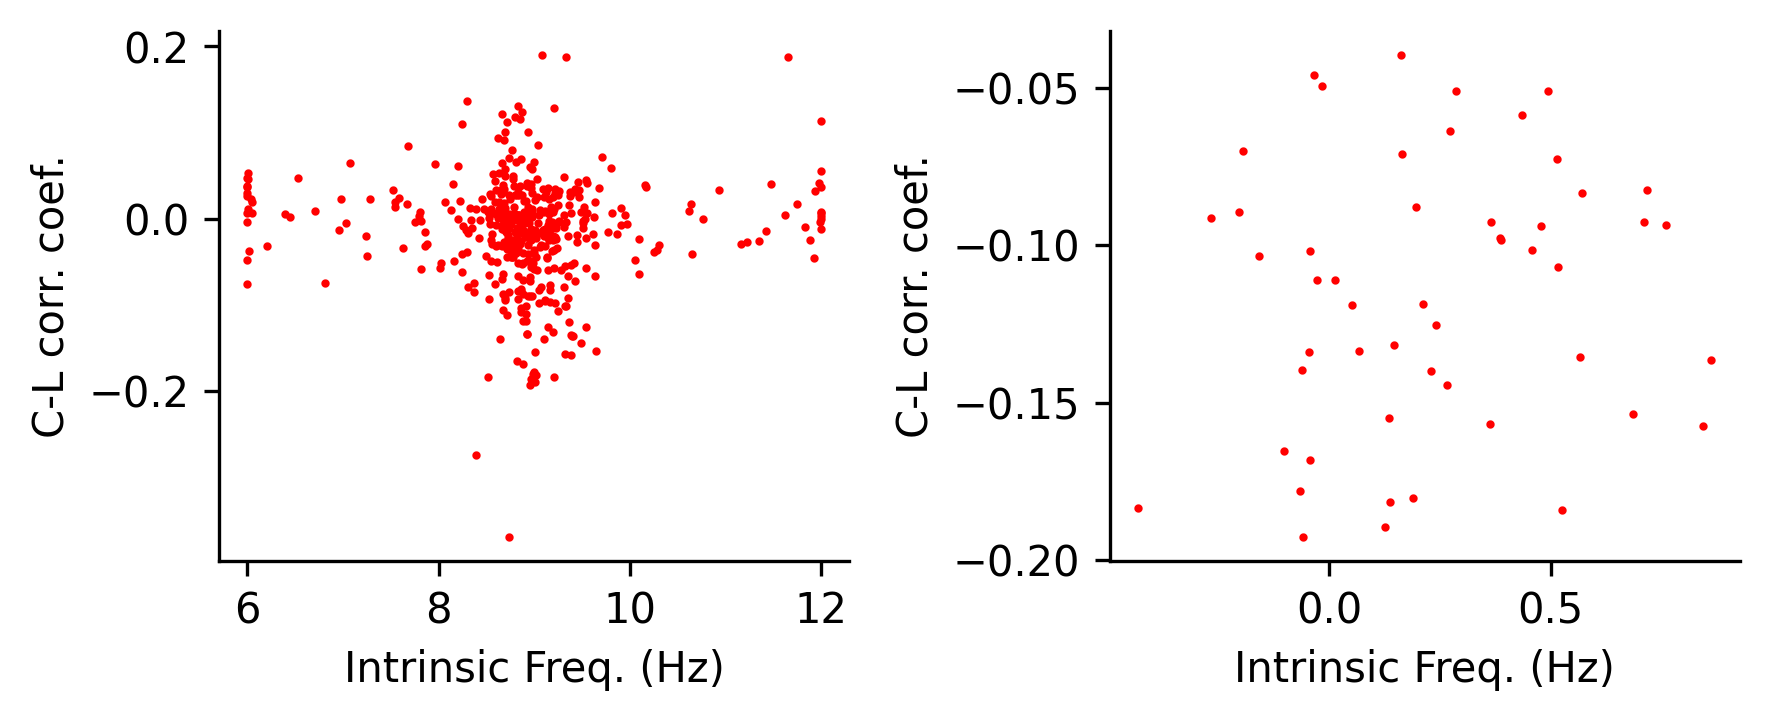

In [9]:
#plot intrinsic frequency against circ-linear correlation for all cells

fig, axs = plt.subplots(1,2,figsize=(6, 2.5), dpi=300)

ax = axs[0]
#plot intrinsic freq against circ-linear correlation for all cells
ax.scatter(all_intrinsic_freq, all_clr, color='red', label='All', s=1)

ax = axs[1]
#do this only for theta_ppp<0.05 and clr<0
indx = np.where((np.array(all_ppp) < 0.05) 
                & (np.array(all_clr) < 0)
                & (np.array(all_global_freq) >= 7.2)
                & (np.array(all_global_freq) <= 11.8))[0]

ax.scatter(np.array(all_intrinsic_freq)[indx]-np.array(all_global_freq)[indx], np.array(all_clr)[indx], color='red', label='All', s=1)

#correlation test between np.array(all_intrinsic_freq)[indx] and np.array(all_clr)[indx]

from scipy.stats import spearmanr
r, p = spearmanr(np.array(all_intrinsic_freq)[indx], np.array(all_clr)[indx])
print('r:', r, 'p:', p)

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Intrinsic Freq. (Hz)', fontsize=labelsize)
    ax.set_ylabel('C-L corr. coef.', fontsize=labelsize)
    
plt.tight_layout()

## Section 5: demonstration of sin wave fitting to the autocorrelogram of spike train

Intrinsic Theta Frequency: 8.40 Hz


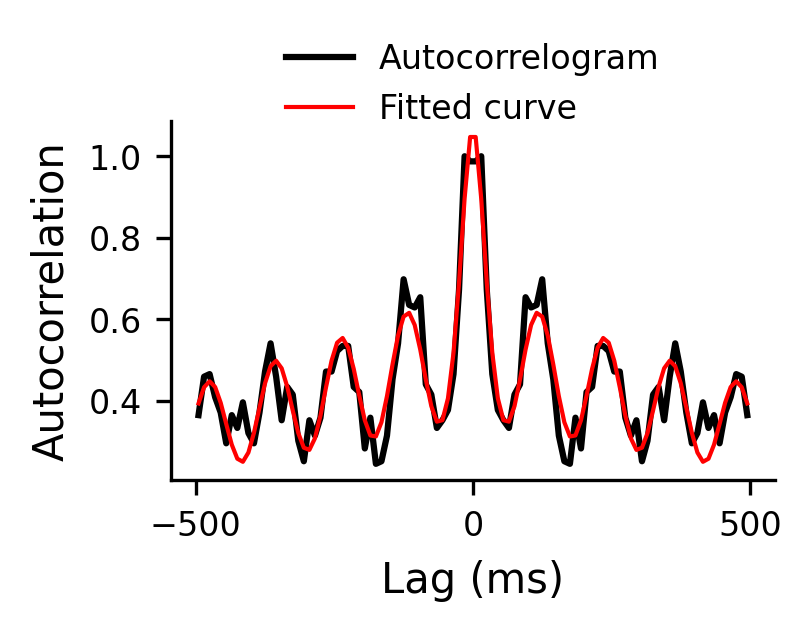

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(2.8, 2.4), dpi=300)

ax = plot_autocorrelogram(ax, autocorrelogram)
plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/autocorrelogram.pdf')

In [11]:
base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'
output_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/autocorrrelogram/all/'
output_skip_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/autocorrrelogram/skip/'
output_nonskip_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/autocorrrelogram/nonskip/'
output_nontheta_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/autocorrrelogram/nontheta/'

# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'speed_threshold': 0.5,
    'duration_threshold': 0.5,
    'speed_smooth_sigma': 40,  #0.8,0.8,40 gives 43% pp cells
    'movingdirection_sigma': 5, #time bin size 20 ms, so 5 is 100 ms
    'interpolation_factor': 1, #1 is 0.02s, and 2 is 0.01s
    'IFR_window':0.2
}

# Create output directories if they don't exist
for dir_path in [output_dir, output_skip_dir, output_nonskip_dir, output_nontheta_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)    
    os.makedirs(dir_path)

total_hd_cells = 0

matnames = {}

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = HD_utils.load_data(ratname, file_path)
                
                if data_dict is not None:
                    ppoh = data_dict['poh']
                    pot = data_dict['pot'].flatten()
                    
                    ppox = data_dict['ppox'].flatten()
                    ppoy = data_dict['ppoy'].flatten()
                    global_freq = data_dict['global_freq'][0][0]
                    
                    #interpolte pot 
                    sampling_interval = np.diff(pot).mean()
                    new_interval = sampling_interval / config['interpolation_factor']
                    pot_interp = np.arange(0, pot[-1], new_interval)
                    
                    for cell_name, cell_data in data_dict['cells_data'].items():
                        psph = cell_data['psph'].flatten()
                        pspt = cell_data['pspt'].flatten()
                        spike_phase = cell_data['spike_phase'].flatten()
                        hd_pval = cell_data['pval'][0][0]
                        hd_mean = cell_data['hd_mean'][0][0]
                        hd_std = cell_data['hd_std'][0][0]
                        tune_width = cell_data['tune_width'][0][0]
                        autocorrelogram = cell_data['autocorrelogram']
                        intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                        hd_rayleigh = cell_data['hd_rayleigh'][0][0]
                        hd_rayleigh_shuffle_99 = cell_data['hd_rayleigh_shuffle_99'][0][0]
                        peak_fr = cell_data['peak_fr'][0][0]
                        intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                        cell_type = cell_data['cell_type']
                        
                        #store matname for each cell
                        matnames[cell_name] = [ratname, file_path]
                        
                        #if hd_pval < 0.05: #select only head direction tuned cells
                        if hd_rayleigh > hd_rayleigh_shuffle_99 and peak_fr > 1: #select only head direction tuned cells with rayleigh vector > 99% shuffle and the peak firing rate in the directional field is greater than 1 Hz
                            try:
                                fig, ax = plt.subplots(1, 1, figsize=(2.8, 2.4), dpi=300)
                                ax, intrinsic_frequency = plot_autocorrelogram(ax, autocorrelogram)
                                
                                output_path = os.path.join(output_dir, f"{cell_name}--{np.round(intrinsic_frequency, 2)}Hz.pdf")
                                
                                plt.tight_layout()
                                plt.savefig(output_path)
                            
                                #save fig according to cell type in different folders
                                if 'Strong ThetaxHD' in cell_type: #This is a theta modulated HD cell
 
                                    if 'skip'in cell_type: #this is a theta skipping cell
                                        output_skip_path = os.path.join(output_skip_dir, f"{cell_name}--{np.round(intrinsic_frequency, 2)}Hz.pdf")
                                        plt.savefig(output_skip_path)
                                    elif 'Strong ThetaxHD' in cell_type: #this is a theta modulated non-skipping cell
                                        output_nonskip_path = os.path.join(output_nonskip_dir, f"{cell_name}--{np.round(intrinsic_frequency, 2)}Hz.pdf")
                                        plt.savefig(output_nonskip_path)
                                elif 'HDC' in cell_type:
                                    output_nontheta_path = os.path.join(output_nontheta_dir, f"{cell_name}--{np.round(intrinsic_frequency, 2)}Hz.pdf")
                                    plt.savefig(output_nontheta_path)
                                    
                                plt.close(fig)
                                total_hd_cells += 1
                            except Exception as e:
                                plt.close(fig)
                                print(f"Error processing {cell_name}: {e}")
                        
print(f"Total number of HD cells processed: {total_hd_cells}")


Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170719_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_100919_T1_sdata.mat
Intrinsic Theta Frequency: 9.83 Hz
Intrinsic Theta Frequency: 7.39 Hz
Intrinsic Theta Frequency: 8.64 Hz
Intrinsic Theta Frequency: 8.62 Hz
Intrinsic Theta Frequency: 8.64 Hz
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_250719_T1_sdata.mat
Intrinsic Theta Frequency: 9.42 Hz
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_090819_T1_sdata.mat
Intrinsic Theta Frequency: 10.84 Hz
Intrinsic Theta Frequency: 9.55 Hz
Intrinsic Theta Frequency: 9.65 Hz
Intrinsic Theta Frequency: 9.62 Hz
Intrinsic Theta Frequency: 10.64 Hz
Processing /home/zilong/Desktop/HDPhas

## Now calculate theta skipping index and analyse the relationship between skipping index and and the degree of phase precession

Intrinsic Theta Frequency: 8.40 Hz


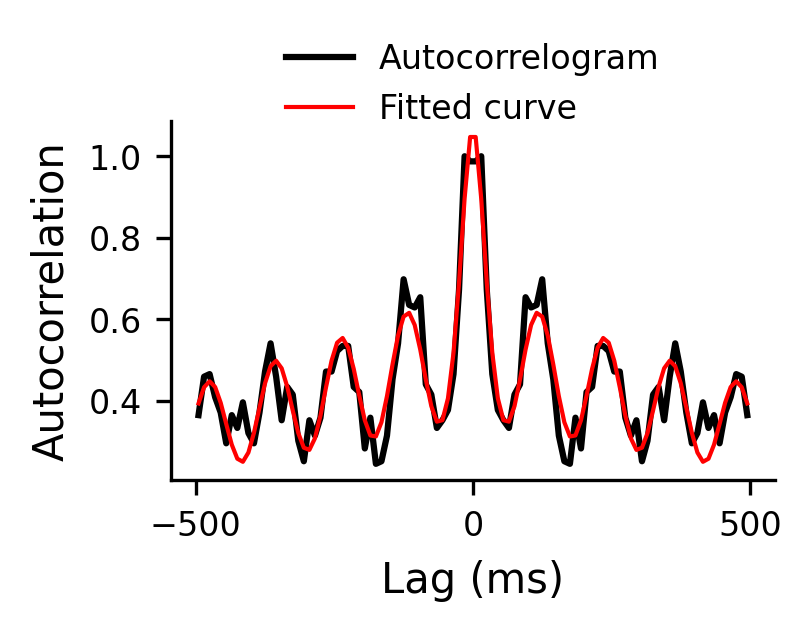

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(2.8, 2.4), dpi=300)

ax = plot_thetaskipping(ax, autocorrelogram)
plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping.pdf')

    

In [71]:
base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'
output_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping/all/'
output_skip_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping/skip/'
output_nonskip_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping/nonskip/'
output_nontheta_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping/nontheta/'

# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'speed_threshold': 0.5,
    'duration_threshold': 0.5,
    'speed_smooth_sigma': 40,  #0.8,0.8,40 gives 43% pp cells
    'movingdirection_sigma': 5, #time bin size 20 ms, so 5 is 100 ms
    'interpolation_factor': 1, #1 is 0.02s, and 2 is 0.01s
    'IFR_window':0.2
}

# Create output directories if they don't exist
for dir_path in [output_dir, output_skip_dir, output_nonskip_dir, output_nontheta_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)    
    os.makedirs(dir_path)

theta_ppp = []
theta_clr = []
theta_TS = []


total_hd_cells = 0

matnames = {}

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = HD_utils.load_data(ratname, file_path)
                
                if data_dict is not None:
                    ppoh = data_dict['poh']
                    pot = data_dict['pot'].flatten()
                    
                    ppox = data_dict['ppox'].flatten()
                    ppoy = data_dict['ppoy'].flatten()
                    global_freq = data_dict['global_freq'][0][0]
                    
                    #interpolte pot 
                    sampling_interval = np.diff(pot).mean()
                    new_interval = sampling_interval / config['interpolation_factor']
                    pot_interp = np.arange(0, pot[-1], new_interval)
                    
                    for cell_name, cell_data in data_dict['cells_data'].items():
                        psph = cell_data['psph'].flatten()
                        pspt = cell_data['pspt'].flatten()
                        spike_phase = cell_data['spike_phase'].flatten()
                        hd_pval = cell_data['pval'][0][0]
                        hd_mean = cell_data['hd_mean'][0][0]
                        hd_std = cell_data['hd_std'][0][0]
                        tune_width = cell_data['tune_width'][0][0]
                        autocorrelogram = cell_data['autocorrelogram']
                        intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                        hd_rayleigh = cell_data['hd_rayleigh'][0][0]
                        hd_rayleigh_shuffle_99 = cell_data['hd_rayleigh_shuffle_99'][0][0]
                        peak_fr = cell_data['peak_fr'][0][0]
                        intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                        cell_type = cell_data['cell_type']
                        
                        #store matname for each cell
                        matnames[cell_name] = [ratname, file_path]
                        
                        #if hd_pval < 0.05: #select only head direction tuned cells
                        if hd_rayleigh > hd_rayleigh_shuffle_99 and peak_fr > 1: #select only head direction tuned cells with rayleigh vector > 99% shuffle and the peak firing rate in the directional field is greater than 1 Hz
                            try:
                                #get results for phase precession against tuning angle
                                pval, clr = get_phaseprecession(ppoh, pot, pspt, psph, hd_mean, spike_phase, config)
                                
                                fig, ax = plt.subplots(1, 1, figsize=(2.8, 2.4), dpi=300)
                                ax, TS = plot_thetaskipping(ax, autocorrelogram)
                                
                                output_path = os.path.join(output_dir, f"{cell_name}--{np.round(TS, 2)}Hz.pdf")
                                
                                plt.tight_layout()
                                plt.savefig(output_path)
                            
                                #save fig according to cell type in different folders
                                if 'Strong ThetaxHD' in cell_type: #This is a theta modulated HD cell
                                    theta_ppp.append(pval)
                                    theta_clr.append(clr)
                                    theta_TS.append(TS)
                                    
                                    if 'skip'in cell_type: #this is a theta skipping cell
                                        output_skip_path = os.path.join(output_skip_dir, f"{cell_name}--{np.round(TS, 2)}Hz.pdf")
                                        plt.savefig(output_skip_path)
                                    elif 'Strong ThetaxHD' in cell_type: #this is a theta modulated non-skipping cell
                                        output_nonskip_path = os.path.join(output_nonskip_dir, f"{cell_name}--{np.round(TS, 2)}Hz.pdf")
                                        plt.savefig(output_nonskip_path)
                                elif 'HDC' in cell_type:
                                    output_nontheta_path = os.path.join(output_nontheta_dir, f"{cell_name}--{np.round(TS, 2)}Hz.pdf")
                                    plt.savefig(output_nontheta_path)
                                    
                                plt.close(fig)
                                total_hd_cells += 1
                            except Exception as e:
                                plt.close(fig)
                                print(f"Error processing {cell_name}: {e}")
                        
print(f"Total number of HD cells processed: {total_hd_cells}")


Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170719_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_100919_T1_sdata.mat
Omega: 14.84 Hz
Theta Cycle Skipping Index: -0.34
Omega: 16.12 Hz
Theta Cycle Skipping Index: -0.24
Omega: 13.47 Hz
Theta Cycle Skipping Index: -0.38
Omega: 16.39 Hz
Theta Cycle Skipping Index: -0.49
Omega: 17.25 Hz
Theta Cycle Skipping Index: -0.15
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_250719_T1_sdata.mat
Omega: 10.00 Hz
Theta Cycle Skipping Index: -1.00
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_090819_T1_sdata.mat
Omega: 16.71 Hz
Theta Cycle Skipping Index: -0.32
Omega: 17.18 Hz
Theta Cycle Skipping Index: -0.29
Omega: 12.31 Hz
Theta Cyc

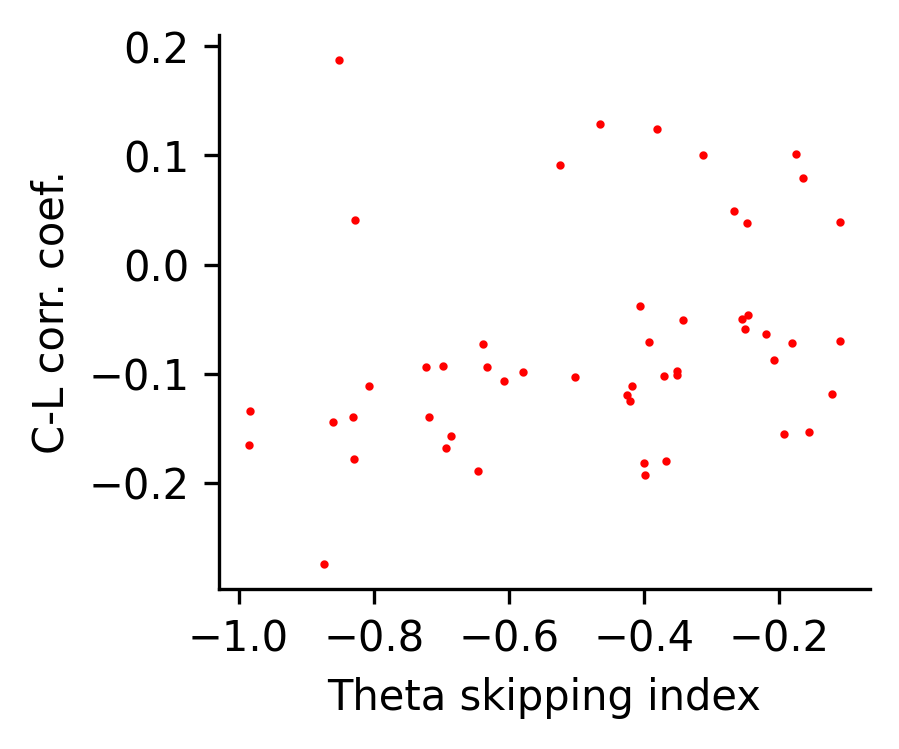

In [74]:
#plot theta_clr against theta_TS for theta_ppp<0.05
fig, ax = plt.subplots(1, 1, figsize=(2.8, 2.4), dpi=300)

indx = np.where(np.array(theta_ppp) < 0.05)[0]
ax.scatter(np.array(theta_TS)[indx], np.array(theta_clr)[indx], color='red', label='Theta', s=1)

ax.set_xlabel('Theta skipping index', fontsize=labelsize)
ax.set_ylabel('C-L corr. coef.', fontsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [67]:
theta_TS

[8.644746889535824,
 8.738361366093905,
 8.73125893958663,
 8.619244360220627,
 8.646514202072696,
 8.66891234123447,
 8.754599633487171,
 8.665745284595829,
 8.771791389432437,
 8.70924454116322,
 9.118414321565247,
 8.93600885087699,
 8.48176317440718,
 8.648995628628132,
 8.636568015398657,
 9.177301636094281,
 9.131294152761798,
 8.668019363233531,
 8.607098245260332,
 8.6841955990835,
 8.895550850792977,
 8.554969780662724,
 8.71890174654153,
 9.192171832954632,
 8.618798148202652,
 8.788526785399426,
 8.553187623098967,
 8.733878097022348,
 8.74378103649259,
 8.679475174589951,
 8.531370759826036,
 8.93095351505526,
 8.62987351263414,
 9.419377088409242,
 8.740310687948513,
 8.62524833894198,
 8.554256588228554,
 8.401335332400366,
 8.579593657188461,
 8.68324819498222,
 8.748983911031184,
 9.362204611253828,
 8.713779668075036,
 8.635415293327044,
 8.554924979728533,
 8.112890767563027,
 8.8365934378626,
 8.955112873048217,
 8.160344345904907,
 9.798791158983045,
 8.360600051202